## NEWSnet_2D_colour_v1
* key features
    * 4-20 Conv layers
        * 2 residual parts of (Convolution block + 2 Identity blocks)
    * 32--32--32/32/128--64/64/256 filters
    * early dropout (rate=0.2) + 2 dropout layers (rate=0.7 and 0.3) + 2 dropout (rate=0.4) after residual Convs
    * SWISH activation functions
    * Nadam optimizer
    * 2-class classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc, shutil, time
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import skimage.transform
from tqdm import tqdm

#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from cnn_utils import *

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D, Concatenate, Add
import keras.optimizers, keras.metrics, keras.losses
from keras.models import Model, load_model
from keras.utils import multi_gpu_model
from keras.constraints import MaxNorm
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import HDF5Matrix, to_categorical

import tensorflow as tf
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects
K.set_image_data_format('channels_last')
from keras.preprocessing.image import ImageDataGenerator

#tf.logging.set_verbosity(tf.logging.ERROR)
#[d.device_type+' '+str(d.memory_limit_bytes//1024**2)+' Mb' for d in K.get_session().list_devices()]

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [3]:
# adding a custom activation function
get_custom_objects().update({'swish': swish})

def balanced_crossentropy(mu=0.2, n_sig_cl=3):
    def bentropy(y_true, y_pred):
        y_tbin = K.sum(y_true[:,:n_sig_cl], axis=1)
        y_pbin = K.sum(y_pred[:,:n_sig_cl], axis=1)
        return mu*keras.losses.categorical_crossentropy(y_true, y_pred) + keras.losses.binary_crossentropy(y_tbin, y_pbin)
    return bentropy

In [4]:
def net_create_2d(n_cl=5, n_sig_cl=3, n_rot=6, checkpoint_name=None, drop_middle=0.7, drop_end=0.3, n_conv2=32, n_conv3=64, n_resid=3, loss_mu=0.8, lr=6e-4, betaa1=30, betaa2=100, decay=1e-3):
    
    n_conv3 = max(n_conv2, n_conv3)
    get_custom_objects().update({'swish': swish})
    
    def newsnet_model_2d(input_shape=(40,40,4)):

        X_input = Input(input_shape)
        X = Conv2D(32, 3, padding='valid', kernel_constraint=MaxNorm(4., axis=[0,1,2]), activation='swish', name='conv2d_1_1')(X_input)
        X = Conv2D(n_conv2, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2]), activation='swish', name='conv2d_1_2')(X)
        X = MaxPooling2D(name='pool1')(X)

        dr0 = min(0.4, max(0.1,1.2-drop_middle-drop_end))
        X = Dropout(rate=dr0, name='drop_start')(X)
        
        X = convolutional_block_2d(X, f = 3, s = 2, filters = [n_conv3,n_conv3, n_conv3*4], stage = 3, block='a')
        res_count = 1
        while(res_count<n_resid):
            X = identity_block_2d(X, 3, [n_conv3,n_conv3, 4*n_conv3], stage=3, block=chr(ord('a')+res_count))
            res_count += 1
        X = MaxPooling2D(padding='same', name='pool3')(X)

        X = Dropout(rate=drop_middle, name='drop_middle')(X)

        X = convolutional_block_2d(X, f = 3, s = 1, filters = [n_conv3*2,n_conv3*2, n_conv3*8], stage = 4, block='a')
        res_count = 1
        while(res_count<n_resid):
            X = identity_block_2d(X, 3, [2*n_conv3,2*n_conv3, 8*n_conv3], stage=4, block=chr(ord('a')+res_count))
            res_count += 1

        X = Dropout(rate=drop_end, name='drop')(X)

        X = Flatten()(X)
        X = Dense(n_cl, activation='softmax', name='multi-class')(X)

        return Model(inputs = X_input, outputs = X, name='conv_res_model')
    
    K.clear_session()
    if loss_mu>1: lr /= loss_mu
    nadamka = keras.optimizers.Nadam(lr=lr, beta_1=1-1./betaa1, beta_2=1-1./betaa2, schedule_decay=decay)
    
    with tf.device('/cpu:0'):
        model_cpu = newsnet_model_2d()
    newsmodel = multi_gpu_model(model_cpu, gpus=2)
    #newsmodel = newsnet_model_2d()
    
    newsmodel.compile(optimizer=nadamka, loss=balanced_crossentropy(mu=loss_mu, n_sig_cl=n_sig_cl))
    return newsmodel

In [5]:
from keras.wrappers.scikit_learn import KerasClassifier
class KerasClassifierNews(KerasClassifier):
    
    def fit(self, X, y, **kwargs):
        
        if not hasattr(self, 'model'): self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        
        print('\n',self.sk_params,'\n')
        
        if self.n_rot:
            angles_list = 90./self.n_rot*np.arange(-self.n_rot,self.n_rot+1)
            train_gen = Batch_data_augmentator_np(X[:-self.small_val], y[:-self.small_val], batch_size=self.batch_size, angles_list=angles_list, multiclass=(self.n_classes_>1), n_cl=self.n_classes_)
        else: train_gen = Batch_data_generator_np(X[:-self.small_val], y[:-self.small_val], batch_size=self.batch_size, multiclass=(self.n_classes_>1), n_cl=self.n_classes_)
        
        chpoint=None
        if self.chp_name:
            if not os.path.exists('networks/checkpoints/'):
                os.makedirs('networks/checkpoints/')
            chpoint = [ModelCheckpoint(filepath='networks/checkpoints/'+self.chp_name+'{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=False, save_weights_only=True, verbose=1, period=1)]
        
        steps = (X.shape[0]-self.small_val)*2//self.batch_size
        multargs = dict(max_queue_size=10, workers=4, use_multiprocessing=True) if self.n_rot else dict(use_multiprocessing=False)
        hist_tmp = self.model.fit_generator(train_gen, epochs=self.Nep, steps_per_epoch=steps, callbacks=chpoint,
                                            validation_data=(X[-self.small_val:], to_categorical(y[-self.small_val:], num_classes=self.n_classes_)), verbose=self.verbose, **multargs)
        last_losses = np.array([hist_tmp.history['val_loss'][-1]])
        while hist_tmp.history['val_loss'][-1]>np.median(hist_tmp.history['val_loss'][-3:]) or (last_losses<hist_tmp.history['val_loss'][-1]).any():
            hist_tmp = self.model.fit_generator(train_gen, epochs=3, steps_per_epoch=steps, 
                                                validation_data=(X[-self.small_val:], to_categorical(y[-self.small_val:], num_classes=self.n_classes_)), verbose=self.verbose, **multargs)
            last_losses = np.append(last_losses, hist_tmp.history['val_loss'][-1])
        del hist_tmp, train_gen; gc.collect();
        
    def predict_proba(self, X, **kwargs):
        return self.model.predict(X, batch_size=self.batch_size, verbose=self.verbose)
    
    def score(self, X, y, **kwargs):
        y_pred = self.predict_proba(X)
        y_true_sb = y<self.n_sig_cl
        preds_sb = np.sum(y_pred[:,:self.n_sig_cl],axis=1)
        return roc_auc_score(y_true_sb, preds_sb)
    
    def save_model(self, mod_path):
        if mod_path.endswith('.h5'): mod_path = mod_path[:-3]
        self.model.save(mod_path+'.h5')
        self.model.save_weights(mod_path+'_weights.h5')
    
    def load_model(self, mod_path, custom_objects=None):
        if mod_path.endswith('.h5'): mod_path = mod_path[:-3]
        self.model = load_model(mod_path+'.h5', custom_objects=custom_objects) #self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        
        print('\n',self.sk_params,'\n')
        
    def load_weights(self, weights_path):
        if not weights_path.endswith('.h5'): weights_path += '.h5'
        self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        
        self.model.load_weights(weights_path)

In [6]:
import inspect
inspect.getfullargspec(keras.Sequential.fit)

FullArgSpec(args=['self', 'x', 'y', 'batch_size', 'epochs', 'verbose', 'callbacks', 'validation_split', 'validation_data', 'shuffle', 'class_weight', 'sample_weight', 'initial_epoch', 'steps_per_epoch', 'validation_steps', 'validation_freq', 'max_queue_size', 'workers', 'use_multiprocessing'], varargs=None, varkw='kwargs', defaults=(None, None, None, 1, 1, None, 0.0, None, True, None, None, 0, None, None, 1, 10, 1, False), kwonlyargs=[], kwonlydefaults=None, annotations={})

### run BAYES optimization

* 150 iterations

In [6]:
import skopt, joblib
from skopt import BayesSearchCV, callbacks
param_dist = {
    "drop_middle": (0.3,0.7),
    "drop_end": (0,0.4),
    "n_conv2": (32,64),
    "n_conv3": (32,64),
    "n_resid": (1,4),
    "loss_mu": (0.01,2),
    "lr": (1e-6, 3e-3, 'log-uniform'),
    "betaa1": (10,100),
    "betaa2": (100,1500),
    "decay": (1e-4, 1e-1, 'log-uniform')
}
init_params = dict(n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=30, validation_split=3000, verbose=0, checkpoint_name=None)

test_kek = KerasClassifierNews(build_fn=net_create_2d, **init_params)
test_bay = BayesSearchCV(test_kek, param_dist, n_iter=150, cv=3, verbose=0, return_train_score=True, refit=False)
checkpoint_bay = callbacks.CheckpointSaver('./bayes_checkpointsaver.pkl')
def checkpoint_dump(optim_res):
    joblib.dump(test_bay, './bayes_checkpoint.pkl')
def checkpoint_results(optim_res):
    pd.DataFrame(test_bay.cv_results_).to_csv('./bayes_checkpoint_results.csv')

In [7]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/'
with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][:N//2], data_sb['train/labels'][:N//2]

test_bay.fit(X_tr, y_tr, callback=[checkpoint_dump, checkpoint_results, checkpoint_bay])


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 30, 'validation_split': 3000, 'verbose': 0, 'checkpoint_name': None, 'betaa1': 93, 'betaa2': 1360, 'decay': 0.03795403684707464, 'drop_end': 0.268317763769018, 'drop_middle': 0.43073931839172386, 'loss_mu': 1.3223479507548144, 'lr': 0.0002986050526821056, 'n_conv2': 40, 'n_conv3': 64, 'n_resid': 2} 


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 30, 'validation_split': 3000, 'verbose': 0, 'checkpoint_name': None, 'betaa1': 93, 'betaa2': 1360, 'decay': 0.03795403684707464, 'drop_end': 0.268317763769018, 'drop_middle': 0.43073931839172386, 'loss_mu': 1.3223479507548144, 'lr': 0.0002986050526821056, 'n_conv2': 40, 'n_conv3': 64, 'n_resid': 2} 


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 30, 'validation_split': 3000, 'verbose': 0, 'checkpoint_name': None, 'betaa1': 93, 'betaa2': 1360, 'decay': 0.03795403684707464, 'drop_end': 0.268317763769018, 'drop_middle': 0.430739318

BayesSearchCV(cv=3, error_score='raise',
              estimator=<__main__.KerasClassifierNews object at 0x7f5318a28f50>,
              fit_params=None, iid=True, n_iter=150, n_jobs=1, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=False, return_train_score=True, scoring=None,
              search_spaces={'betaa1': (10, 100), 'betaa2': (100, 1500),
                             'decay': (0.0001, 0.1, 'log-uniform'),
                             'drop_end': (0, 0.4), 'drop_middle': (0.3, 0.7),
                             'loss_mu': (0.01, 2),
                             'lr': (1e-06, 0.003, 'log-uniform'),
                             'n_conv2': (32, 64), 'n_conv3': (32, 64),
                             'n_resid': (1, 4)},
              verbose=0)

In [8]:
bay_res = pd.DataFrame(test_bay.cv_results_)
bay_res.to_csv('bayes_results.csv')
bay_res = bay_res.sort_values(by='mean_test_score', ascending=False, axis=0)
bay_res.reset_index(inplace=True, drop=True)
bay_res.to_csv('bayes_results_sorted.csv')

In [9]:
bay_res.drop(columns=['rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score'])

,mean_test_score,std_test_score,mean_train_score,std_train_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_betaa1,param_betaa2,param_decay,param_drop_end,param_drop_middle,param_loss_mu,param_lr,param_n_conv2,param_n_conv3,param_n_resid,params,rank_train_score
0,0.993123,0.002758,0.994281,0.002936,2960.049399,1346.853981,5.009962,0.040513,100,1500,0.015560,0.000000,0.688433,0.010000,0.000446,64,39,2,"{'betaa1': 100, 'betaa2': 1500, 'decay': 0.015...",1
1,0.991958,0.002238,0.993328,0.002126,2424.116742,73.443270,7.848715,0.039114,10,100,0.100000,0.184856,0.479822,2.000000,0.001474,64,34,4,"{'betaa1': 10, 'betaa2': 100, 'decay': 0.1, 'd...",2
2,0.991485,0.003015,0.993044,0.002558,2123.034308,191.664765,7.769687,0.083960,100,1342,0.015687,0.000000,0.504601,2.000000,0.001999,64,64,4,"{'betaa1': 100, 'betaa2': 1342, 'decay': 0.015...",3
3,0.991434,0.001366,0.992364,0.001729,1778.999481,78.377617,6.998163,0.097513,100,100,0.100000,0.000000,0.300000,0.010000,0.001943,51,32,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.1, '...",5
4,0.991347,0.000470,0.992639,0.000455,2066.426211,95.374293,7.823511,0.022915,100,100,0.100000,0.000000,0.617035,0.010000,0.002378,64,59,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.1, '...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.918021,0.010601,0.918376,0.012731,2061.284992,120.267034,7.842632,0.068842,100,582,0.069918,0.031661,0.300000,2.000000,0.000028,64,60,4,"{'betaa1': 100, 'betaa2': 582, 'decay': 0.0699...",146
146,0.865828,0.006751,0.866271,0.006745,1364.931787,4.382688,4.881005,0.055215,61,1103,0.014051,0.316207,0.678462,1.938057,0.000013,64,39,2,"{'betaa1': 61, 'betaa2': 1103, 'decay': 0.0140...",147
147,0.823903,0.004743,0.824413,0.005742,1565.028876,18.240301,6.078663,0.007143,83,572,0.000100,0.000000,0.638161,0.010000,0.000005,43,61,3,"{'betaa1': 83, 'betaa2': 572, 'decay': 0.0001,...",148
148,0.803376,0.014448,0.804235,0.015777,1024.862761,3.991888,4.018238,0.040971,96,143,0.009622,0.026580,0.316664,0.268169,0.000002,33,36,2,"{'betaa1': 96, 'betaa2': 143, 'decay': 0.00962...",149


In [10]:
bay_param = pd.DataFrame(list(bay_res['params']))
bay_param.to_csv('bayes_params_sorted.csv')
bay_param

,betaa1,betaa2,decay,drop_end,drop_middle,loss_mu,lr,n_conv2,n_conv3,n_resid
0,100,1500,0.015560,0.000000,0.688433,0.010000,0.000446,64,39,2
1,10,100,0.100000,0.184856,0.479822,2.000000,0.001474,64,34,4
2,100,1342,0.015687,0.000000,0.504601,2.000000,0.001999,64,64,4
3,100,100,0.100000,0.000000,0.300000,0.010000,0.001943,51,32,4
4,100,100,0.100000,0.000000,0.617035,0.010000,0.002378,64,59,4
...,...,...,...,...,...,...,...,...,...,...
145,100,582,0.069918,0.031661,0.300000,2.000000,0.000028,64,60,4
146,61,1103,0.014051,0.316207,0.678462,1.938057,0.000013,64,39,2
147,83,572,0.000100,0.000000,0.638161,0.010000,0.000005,43,61,3
148,96,143,0.009622,0.026580,0.316664,0.268169,0.000002,33,36,2


In [11]:
7*24/(3100/3600)

195.09677419354838

## using the best result of Bayes Opt

In [7]:
from collections import OrderedDict
#bay_param = pd.read_csv('bayes_params_sorted.csv', index_col=0)
bay_res = pd.read_csv('bayes_checkpoint_results.csv', index_col=0).sort_values(by='mean_test_score', ascending=False, axis=0)
bay_param = pd.DataFrame([eval(i) for i in bay_res['params']], index=bay_res['params'].index)
dict_bay_param = dict(bay_param.iloc[0])
for k, val in dict_bay_param.items():
    if k.startswith('n_'): dict_bay_param[k] = int(val)
dict_bay_param

{'betaa1': 100.0,
 'betaa2': 1500.0,
 'decay': 0.015560370138015383,
 'drop_end': 0.0,
 'drop_middle': 0.6884329966834594,
 'loss_mu': 0.01,
 'lr': 0.00044557109681541026,
 'n_conv2': 64,
 'n_conv3': 39,
 'n_resid': 2}

In [8]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/70nm/'
with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create_2d, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=70, validation_split=3000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 70, 'validation_split': 3000, 'verbose': 1, 'checkpoint_name': 'ensemble_estimators', 'betaa1': 100.0, 'betaa2': 1500.0, 'decay': 0.015560370138015383, 'drop_end': 0.0, 'drop_middle': 0.6884329966834594, 'loss_mu': 0.01, 'lr': 0.00044557109681541026, 'n_conv2': 64, 'n_conv3': 39, 'n_resid': 2} 

Epoch 1/70
459/459 [==============================] - 144s 315ms/step - loss: 0.4465 - val_loss: 0.9230

Epoch 00001: saving model to networks/checkpoints/ensemble_estimators01-0.92.h5
Epoch 2/70
459/459 [==============================] - 133s 289ms/step - loss: 0.2298 - val_loss: 0.8284

Epoch 00002: saving model to networks/checkpoints/ensemble_estimators02-0.83.h5
Epoch 3/70
459/459 [==============================] - 133s 290ms/step - loss: 0.2006 - val_loss: 0.6570

Epoch 00003: saving model to networks/checkpoints/ensemble_estimators03-0.66.h5
Epoch 4/70
459/459 [==============================] - 133s 290ms/step - loss: 

In [9]:
os.listdir('networks/checkpoints/')

['ensemble_estimators57-0.17.h5',
 'ensemble_estimators34-0.19.h5',
 'ensemble_estimators61-0.12.h5',
 'ensemble_estimators54-0.15.h5',
 'ensemble_estimators56-0.12.h5',
 'ensemble_estimators27-0.08.h5',
 'ensemble_estimators02-0.83.h5',
 'ensemble_estimators01-0.92.h5',
 'ensemble_estimators48-0.15.h5',
 'ensemble_estimators41-0.29.h5',
 'ensemble_estimators12-0.34.h5',
 'ensemble_estimators35-0.18.h5',
 'ensemble_estimators67-0.15.h5',
 'ensemble_estimators05-0.93.h5',
 'ensemble_estimators36-0.25.h5',
 'ensemble_estimators07-0.17.h5',
 'ensemble_estimators58-0.26.h5',
 'ensemble_estimators31-0.15.h5',
 'ensemble_estimators64-0.13.h5',
 'ensemble_estimators39-0.44.h5',
 'ensemble_estimators22-0.10.h5',
 'ensemble_estimators59-0.28.h5',
 'ensemble_estimators29-0.14.h5',
 'ensemble_estimators11-0.30.h5',
 'ensemble_estimators28-0.14.h5',
 'ensemble_estimators23-0.47.h5',
 'ensemble_estimators06-0.18.h5',
 'ensemble_estimators08-0.31.h5',
 'ensemble_estimators42-0.10.h5',
 'ensemble_est

(0.0, 0.4)

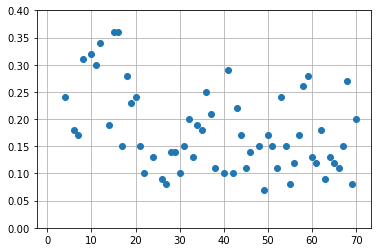

In [15]:
chp_tmp = os.listdir('networks/checkpoints/')
ep_tmp, loss_tmp = [],[]
for chp in chp_tmp:
    ep_tmp.append(int(chp.split('-')[0].split('tors')[1]))
    loss_tmp.append(float(chp.split('-')[1][:-3]))
plt.plot(ep_tmp, loss_tmp, 'o')
plt.grid()
plt.ylim(0,0.4)

In [16]:
# best_kek.save_model('networks/model_150iter_4cl.h5')
del X_tr, y_tr; gc.collect();

In [13]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/'
with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create_2d, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=50, validation_split=3000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 50, 'validation_split': 3000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 100.0, 'betaa2': 1500.0, 'decay': 0.015560370138015383, 'drop_end': 0.0, 'drop_middle': 0.6884329966834594, 'loss_mu': 0.01, 'lr': 0.00044557109681541026, 'n_conv2': 64, 'n_conv3': 39, 'n_resid': 2} 

Epoch 1/50
459/459 [==============================] - 147s 320ms/step - loss: 0.4291 - val_loss: 3.5534
Epoch 2/50
459/459 [==============================] - 135s 294ms/step - loss: 0.2298 - val_loss: 0.4140
Epoch 3/50
459/459 [==============================] - 135s 294ms/step - loss: 0.1967 - val_loss: 0.2088
Epoch 4/50
459/459 [==============================] - 135s 295ms/step - loss: 0.1745 - val_loss: 0.4306
Epoch 5/50
459/459 [==============================] - 135s 294ms/step - loss: 0.1594 - val_loss: 0.5569
Epoch 6/50
459/459 [==============================] - 135s 294ms/step - loss: 0.1494 - val_loss: 0.2026
Epoch 7/50
459/459 [======

## using the SECOND-to-best result of Bayes Opt

In [7]:
from collections import OrderedDict
#bay_param = pd.read_csv('bayes_params_sorted.csv', index_col=0)
bay_res = pd.read_csv('bayes_checkpoint_results.csv', index_col=0).sort_values(by='mean_test_score', ascending=False, axis=0)
bay_param = pd.DataFrame([eval(i) for i in bay_res['params']], index=bay_res['params'].index)
dict_bay_param = dict(bay_param.iloc[1])
for k, val in dict_bay_param.items():
    if k.startswith('n_'): dict_bay_param[k] = int(val)
dict_bay_param

{'betaa1': 10.0,
 'betaa2': 100.0,
 'decay': 0.1,
 'drop_end': 0.18485585416820177,
 'drop_middle': 0.47982200340742287,
 'loss_mu': 2.0,
 'lr': 0.0014739165771018563,
 'n_conv2': 64,
 'n_conv3': 34,
 'n_resid': 4}

In [8]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/70nm/'
with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create_2d, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=70, validation_split=3000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 70, 'validation_split': 3000, 'verbose': 1, 'checkpoint_name': 'ensemble_estimators', 'betaa1': 10.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.18485585416820177, 'drop_middle': 0.47982200340742287, 'loss_mu': 2.0, 'lr': 0.0014739165771018563, 'n_conv2': 64, 'n_conv3': 34, 'n_resid': 4} 

Epoch 1/70
459/459 [==============================] - 221s 482ms/step - loss: 2.3976 - val_loss: 6.2952

Epoch 00001: saving model to networks/checkpoints/ensemble_estimators01-6.30.h5
Epoch 2/70
459/459 [==============================] - 198s 431ms/step - loss: 1.6412 - val_loss: 4.3436

Epoch 00002: saving model to networks/checkpoints/ensemble_estimators02-4.34.h5
Epoch 3/70
459/459 [==============================] - 198s 432ms/step - loss: 1.4538 - val_loss: 2.5923

Epoch 00003: saving model to networks/checkpoints/ensemble_estimators03-2.59.h5
Epoch 4/70
459/459 [==============================] - 198s 432ms/step - loss: 1.41

In [9]:
os.listdir('networks/checkpoints/')

['ensemble_estimators06-2.39.h5',
 'ensemble_estimators60-1.78.h5',
 'ensemble_estimators59-1.21.h5',
 'ensemble_estimators54-0.99.h5',
 'ensemble_estimators25-1.65.h5',
 'ensemble_estimators43-1.12.h5',
 'ensemble_estimators45-1.03.h5',
 'ensemble_estimators44-1.37.h5',
 'ensemble_estimators04-2.56.h5',
 'ensemble_estimators23-2.90.h5',
 'ensemble_estimators01-6.30.h5',
 'ensemble_estimators63-1.74.h5',
 'ensemble_estimators31-1.55.h5',
 'ensemble_estimators14-1.53.h5',
 'ensemble_estimators35-1.45.h5',
 'ensemble_estimators41-1.01.h5',
 'ensemble_estimators68-0.97.h5',
 'ensemble_estimators34-1.17.h5',
 'ensemble_estimators27-2.00.h5',
 'ensemble_estimators66-1.33.h5',
 'ensemble_estimators40-1.31.h5',
 'ensemble_estimators12-2.05.h5',
 'ensemble_estimators11-2.58.h5',
 'ensemble_estimators10-1.57.h5',
 'ensemble_estimators24-1.07.h5',
 'ensemble_estimators56-0.86.h5',
 'ensemble_estimators48-2.06.h5',
 'ensemble_estimators55-1.28.h5',
 'ensemble_estimators49-1.51.h5',
 'ensemble_est

(0.8, 2.0)

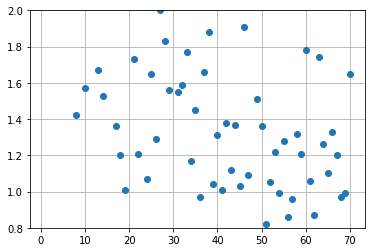

In [17]:
chp_tmp = os.listdir('networks/checkpoints/')
ep_tmp, loss_tmp = [],[]
for chp in chp_tmp:
    ep_tmp.append(int(chp.split('-')[0].split('tors')[1]))
    loss_tmp.append(float(chp.split('-')[1][:-3]))
plt.plot(ep_tmp, loss_tmp, 'o')
plt.grid()
plt.ylim(0.8,2)

In [11]:
# best_kek.save_model('networks/model_150iter_4cl.h5')
del X_tr, y_tr, best_kek; gc.collect();

## using the THIRD-to-best result of Bayes Opt

In [7]:
from collections import OrderedDict
#bay_param = pd.read_csv('bayes_params_sorted.csv', index_col=0)
bay_res = pd.read_csv('bayes_checkpoint_results.csv', index_col=0).sort_values(by='mean_test_score', ascending=False, axis=0)
bay_param = pd.DataFrame([eval(i) for i in bay_res['params']], index=bay_res['params'].index)
dict_bay_param = dict(bay_param.iloc[2])
for k, val in dict_bay_param.items():
    if k.startswith('n_'): dict_bay_param[k] = int(val)
dict_bay_param

{'betaa1': 10.0,
 'betaa2': 100.0,
 'decay': 0.1,
 'drop_end': 0.18485585416820177,
 'drop_middle': 0.47982200340742287,
 'loss_mu': 2.0,
 'lr': 0.0014739165771018563,
 'n_conv2': 64,
 'n_conv3': 34,
 'n_resid': 4}

In [ ]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/70nm/'
with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create_2d, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=70, validation_split=3000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 70, 'validation_split': 3000, 'verbose': 1, 'checkpoint_name': 'ensemble_estimators', 'betaa1': 10.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.18485585416820177, 'drop_middle': 0.47982200340742287, 'loss_mu': 2.0, 'lr': 0.0014739165771018563, 'n_conv2': 64, 'n_conv3': 34, 'n_resid': 4} 

Epoch 1/70
459/459 [==============================] - 221s 482ms/step - loss: 2.3976 - val_loss: 6.2952

Epoch 00001: saving model to networks/checkpoints/ensemble_estimators01-6.30.h5
Epoch 2/70
459/459 [==============================] - 198s 431ms/step - loss: 1.6412 - val_loss: 4.3436

Epoch 00002: saving model to networks/checkpoints/ensemble_estimators02-4.34.h5
Epoch 3/70
459/459 [==============================] - 198s 432ms/step - loss: 1.4538 - val_loss: 2.5923

Epoch 00003: saving model to networks/checkpoints/ensemble_estimators03-2.59.h5
Epoch 4/70
459/459 [==============================] - 198s 432ms/step - loss: 1.41

In [ ]:
os.listdir('networks/checkpoints/')

In [ ]:
chp_tmp = os.listdir('networks/checkpoints/')
ep_tmp, loss_tmp = [],[]
for chp in chp_tmp:
    ep_tmp.append(int(chp.split('-')[0].split('tors')[1]))
    loss_tmp.append(float(chp.split('-')[1][:-3]))
plt.plot(ep_tmp, loss_tmp, 'o')
plt.grid()
plt.ylim(0,0.4)

## Checkpoint ensemble

### Validation data

#### loading the checkpoint models

In [19]:
pred_path = 'networks/predictions/'
if not os.path.exists(pred_path):
    os.makedirs(pred_path)
ensemble_size = 10
weight_names = os.listdir('networks/checkpoints/')
epochs, losses = np.zeros(len(weight_names), dtype=int), np.zeros(len(weight_names))
for i, name in enumerate(weight_names):
    epochs[i] = int(name.split('-')[0][-2:])
    losses[i] = float(name.split('-')[1][:-3])
mask_sort = np.argsort(epochs)
epochs = epochs[mask_sort]; losses = losses[mask_sort]
ensemble = []
last_ep = -1
while len(ensemble)<ensemble_size:
    if losses[last_ep]<1.15:
        chp_name = '{:02d}-{:.2f}'.format(epochs[last_ep], losses[last_ep])  #(str(epochs[last_ep]) if epochs[last_ep]>9 else '0'+str(epochs[last_ep]))
        ensemble.append('networks/checkpoints/ensemble_estimators'+chp_name+'.h5')
    last_ep -= 1
print(len(ensemble), ensemble)

10 ['networks/checkpoints/ensemble_estimators69-0.99.h5', 'networks/checkpoints/ensemble_estimators68-0.97.h5', 'networks/checkpoints/ensemble_estimators65-1.10.h5', 'networks/checkpoints/ensemble_estimators62-0.87.h5', 'networks/checkpoints/ensemble_estimators61-1.06.h5', 'networks/checkpoints/ensemble_estimators57-0.96.h5', 'networks/checkpoints/ensemble_estimators56-0.86.h5', 'networks/checkpoints/ensemble_estimators54-0.99.h5', 'networks/checkpoints/ensemble_estimators52-1.05.h5', 'networks/checkpoints/ensemble_estimators51-0.82.h5']


In [20]:
### Validation data

dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/70nm/'
n_sig_cl = 3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']
with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    X_fog, y_fog = data_sb['val/images'][...], data_sb['val/labels'][...]

start = datetime.now()
for chp_weights_name in ensemble:
    best_kek = KerasClassifierNews(build_fn=net_create_2d, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=70, validation_split=4000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
    best_kek.load_weights(chp_weights_name)
    fog_pred = best_kek.predict_proba(X_fog)
    np.savetxt(pred_path+'predict_'+(chp_weights_name.split('tors')[-1][:-3])+'.txt', fog_pred)
    print('epoch {} ROC AUC: {:.3f}'.format(chp_weights_name.split('tors')[-1].split('-')[0], roc_auc_score((y_fog<3).astype(float), np.sum(fog_pred[:,:n_sig_cl],axis=1))))
    del best_kek; gc.collect()
print('ensemble validation time:', datetime.now()-start)

30600/30600 [==============================] - 10s 322us/step
epoch 69 ROC AUC: 0.996
30600/30600 [==============================] - 9s 303us/step
epoch 68 ROC AUC: 0.998
30600/30600 [==============================] - 10s 315us/step
epoch 65 ROC AUC: 0.998
30600/30600 [==============================] - 10s 314us/step
epoch 62 ROC AUC: 0.998
30600/30600 [==============================] - 10s 313us/step
epoch 61 ROC AUC: 0.996
30600/30600 [==============================] - 10s 314us/step
epoch 57 ROC AUC: 0.998
30600/30600 [==============================] - 10s 318us/step
epoch 56 ROC AUC: 0.998
30600/30600 [==============================] - 10s 317us/step
epoch 54 ROC AUC: 0.997
30600/30600 [==============================] - 9s 295us/step
epoch 52 ROC AUC: 0.997
30600/30600 [==============================] - 10s 311us/step
epoch 51 ROC AUC: 0.998
ensemble validation time: 0:02:36.311975


In [21]:
os.listdir('networks/predictions/')

['predict_57-0.96.txt',
 'predict_54-0.99.txt',
 'predict_56-0.86.txt',
 'predict_62-0.87.txt',
 'predict_51-0.82.txt',
 'predict_69-0.99.txt',
 'predict_61-1.06.txt',
 'predict_65-1.10.txt',
 'predict_52-1.05.txt',
 'predict_68-0.97.txt']

#### validation curves

In [22]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/70nm/'
n_sig_cl = 3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']
col = {'fog':'blue'}
with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    y_fog = data_sb['val/labels'][...]

## SECOND bayes

##### Guide to variables
* mean_curves: TPR, FPR, Threshold (calculated on mean predictions)
* inverse_curves: low_quant, high_quant, mean FPR (interpolated for SAME TPR values as mean_curves)

C30keV vs fog
thresh:	 0.9907566140405833 
eff:	 0.5713235294117647 
rej:	9.80e-05
C60keV vs fog
thresh:	 0.9907566140405833 
eff:	 0.924264705882353 
rej:	9.80e-05
C100keV vs fog
thresh:	 0.9907566140405833 
eff:	 0.970735294117647 
rej:	9.80e-05


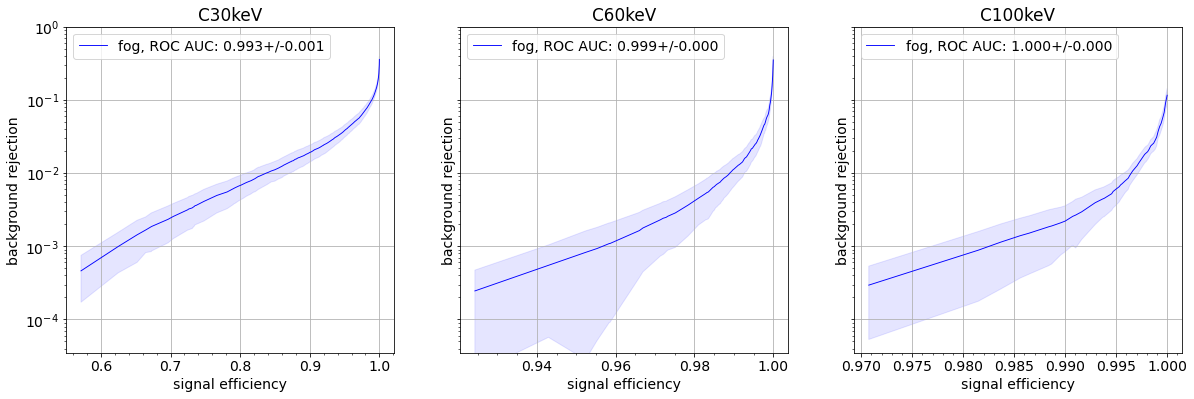

roc plots time: 0:00:06.285234


In [23]:
save_dir = '/home/scanner-ml/ML-drive/Artem/Colour_70nm/Oct2019_Feb2020_N123gf/plots/article/figures/'

import scipy.interpolate
start = datetime.now()
preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
for pred_name in os.listdir('networks/predictions/'):
    pred_name = 'networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign:
        mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)
        aucs[s].append(roc_auc_score(y_true_sb, preds0_sb))

sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
    y_true_sb = y_fog[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        f_mask = fpr>0
        fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value='extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    f_mask = fpr>0
    fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))
    
    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    gc.collect()

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    thresh_half = thr[i_half]
    
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    axes[j].fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=col[b],alpha=0.1 )
   
    axes[j].legend(loc=2)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('signal efficiency')
    #axes[j].set_xlim(0.05, 1.0)
    axes[j].set_ylim(3.5e-5, 1.0)
    axes[j].set_ylabel('background rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.savefig(save_dir+'ml_roc_col_second.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print('roc plots time:', datetime.now()-start)

In [24]:
thresh_half = 0.991

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('networks/predictions/'):
    pred_name = 'networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.655 +/- 0.049
C60keV  	 val score: 0.960 +/- 0.025
C100keV  	 val score: 0.982 +/- 0.012
fog 		 val score: 1.9e-03 +/- 1.1e-03


## Best bayes

##### Guide to variables
* mean_curves: TPR, FPR, Threshold (calculated on mean predictions)
* inverse_curves: low_quant, high_quant, mean FPR (interpolated for SAME TPR values as mean_curves)

C30keV vs fog
thresh:	 0.9916073272004724 
eff:	 0.4616176470588235 
rej:	9.80e-05
C60keV vs fog
thresh:	 0.9916073272004724 
eff:	 0.8325 
rej:	9.80e-05
C100keV vs fog
thresh:	 0.9916073272004724 
eff:	 0.9180882352941176 
rej:	9.80e-05


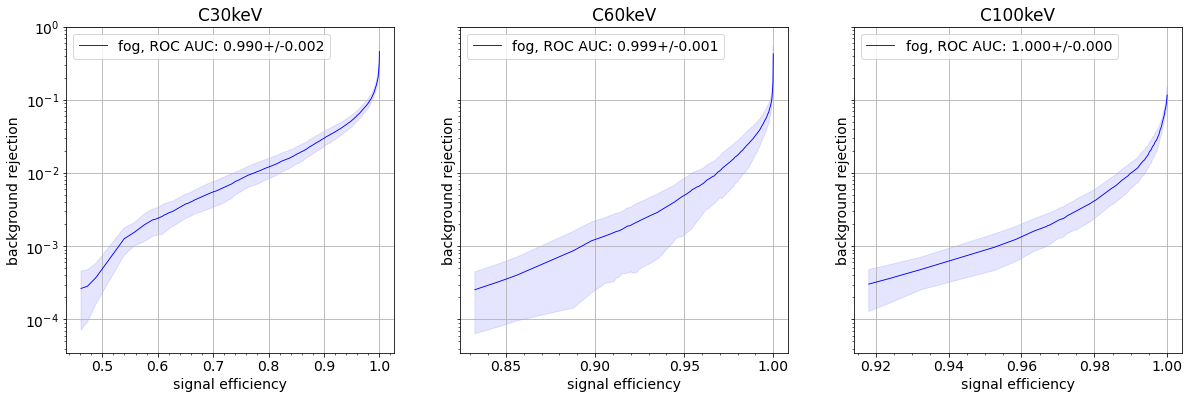

roc plots time: 0:00:06.209681


In [68]:
save_dir = '/home/scanner-ml/ML-drive/Artem/Colour_70nm/Oct2019_Feb2020_N123gf/plots/article/figures/'

import scipy.interpolate
start = datetime.now()
preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
for pred_name in os.listdir('networks/predictions/'):
    pred_name = 'networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign:
        mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)
        aucs[s].append(roc_auc_score(y_true_sb, preds0_sb))

sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
    y_true_sb = y_fog[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        f_mask = fpr>0
        fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value='extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    f_mask = fpr>0
    fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))
    
    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    gc.collect()

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    thresh_half = thr[i_half]
    
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    axes[j].fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=col[b],alpha=0.1 )
   
    axes[j].legend(loc=2)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('signal efficiency')
    #axes[j].set_xlim(0.05, 1.0)
    axes[j].set_ylim(3.5e-5, 1.0)
    axes[j].set_ylabel('background rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.savefig(save_dir+'ml_roc.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print('roc plots time:', datetime.now()-start)

In [43]:
thresh_half = 0.991

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('networks/predictions/'):
    pred_name = 'networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.554 +/- 0.065
C60keV  	 val score: 0.906 +/- 0.041
C100keV  	 val score: 0.951 +/- 0.023
fog 		 val score: 2.1e-03 +/- 1.7e-03


In [45]:
for name in sign_b:
    print(name, '\n', val_score[name])

C30keV 
 [0.49838235 0.51514706 0.50470588 0.56426471 0.58794118 0.78161765
 0.64044118 0.49044118 0.48176471 0.47338235]
C60keV 
 [0.86338235 0.88838235 0.89235294 0.97073529 0.96955882 0.99029412
 0.94441176 0.88705882 0.84779412 0.80573529]
C100keV 
 [0.92014706 0.92102941 0.95441176 0.97941176 0.98235294 0.99632353
 0.98617647 0.9375     0.93764706 0.89970588]
fog 
 [4.90196078e-04 2.94117647e-04 1.27450980e-03 3.43137255e-03
 2.05882353e-03 8.43137255e-03 3.03921569e-03 3.92156863e-04
 1.07843137e-03 9.80392157e-05]


In [47]:
os.listdir('networks/predictions/')

['predict_61-0.12.txt',
 'predict_55-0.08.txt',
 'predict_65-0.12.txt',
 'predict_64-0.13.txt',
 'predict_63-0.09.txt',
 'predict_52-0.11.txt',
 'predict_69-0.08.txt',
 'predict_66-0.11.txt',
 'predict_60-0.13.txt',
 'predict_56-0.12.txt']

#### TEST DATA

* saving test predictions

In [25]:
test_pred_path = 'networks/test_predictions/'
if not os.path.exists(test_pred_path):
    os.makedirs(test_pred_path)
test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

start = datetime.now()
with h5py.File(dset+'data_scale_ims_col_40.h5','r') as df:
    test_preds = {name:[] for name in test_classes}
    for name in test_classes:
        print('testing ',name)
#     for name in df['test'].keys():
        start_ens = datetime.now()
        for chp_weights_name in ensemble:
            best_kek = KerasClassifierNews(build_fn=net_create_2d, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=70, validation_split=4000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
            best_kek.load_weights(chp_weights_name)
            
#             with capture_output() as caput:
#             pols = df['test/'+name+'/pol_ids'][...]
#             mask = np.arange(pols.shape[0])[pols[:,-2]==-1]
            pred = best_kek.predict_proba(df['test/'+name+'/images'])
            preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)#[mask]
            np.savetxt(test_pred_path+(name.split('/')[-1])+'_predict_'+(chp_weights_name.split('tors')[-1][:-3])+'.txt', preds_sb)
            test_preds[name].append(preds_sb)
            del best_kek; gc.collect();
        test_preds[name] = np.array(test_preds[name])
        print('ensemble time:', datetime.now()-start_ens,'\n')
print('testing time:', datetime.now()-start,'\n')


testing  Carbon/30keV
28656/28656 [==============================] - 9s 317us/step
ensemble time: 0:02:30.846561 

testing  Carbon/60keV
45901/45901 [==============================] - 14s 311us/step
ensemble time: 0:03:19.777220 

testing  Carbon/100keV
27101/27101 [==============================] - 9s 333us/step
ensemble time: 0:02:26.497248 

testing  fog
23365/23365 [==============================] - 8s 336us/step
ensemble time: 0:02:16.866842 

testing time: 0:10:33.989954 



* loading test predictions

In [57]:
test_pred_path = 'networks_bestparam/test_predictions/'
test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']
test_preds = {name:[] for name in test_classes}
for pred_name in np.sort(os.listdir(test_pred_path)):
    name = [cl for cl in test_classes if (pred_name.split('_')[0] in cl)][0]
    pred_name = test_pred_path+pred_name
    test_preds[name].append(np.loadtxt(pred_name))
for name in test_classes:
    test_preds[name] = np.array(test_preds[name])

In [58]:
test_preds['Carbon/30keV'].shape

(10, 28656)

In [59]:
categ_dict_test = {'Carbon/30keV': 0, 'Carbon/60keV': 1, 'Carbon/100keV': 2, 'fog': 3}
sign_test = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV']

In [60]:
y_test_tot = np.hstack([np.ones(test_preds[name].shape[-1])*categ_dict_test[name] for name in test_classes])
test_preds_tot = np.hstack([test_preds[name] for name in test_classes])
print(y_test_tot.shape,'\t',test_preds_tot.shape)

(125023,) 	 (10, 125023)


## SECOND bayes

In [30]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.997

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(test_preds[name]>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

test_mean = {name: np.mean(test_score[name]) for name in test_classes}
test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if not 'fog' in name:
        print(name, '\t test score: {:.3f} +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e} +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.149 +/- 0.069
Carbon/60keV 	 test score: 0.932 +/- 0.037
Carbon/100keV 	 test score: 0.970 +/- 0.018
fog 		 test score: 8.6e-04 +/- 5.3e-04


Carbon/30keV vs fog
thresh:	 0.9915573418140411 
eff:	 0.12290619765494137 
rej:	2.14e-04
Carbon/60keV vs fog
thresh:	 0.9904108941555023 
eff:	 0.9065379839219189 
rej:	2.14e-04
Carbon/100keV vs fog
thresh:	 0.9904559552669525 
eff:	 0.9686358436958046 
rej:	2.14e-04


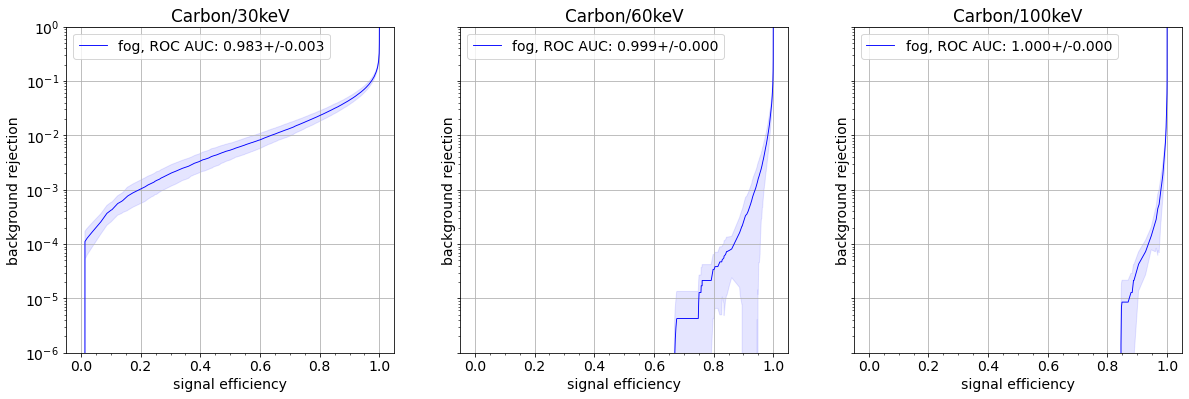

roc plots time: 0:00:03.506054


In [31]:
save_dir = '/home/scanner-ml/ML-drive/Artem/Colour_70nm/Oct2019_Feb2020_N123gf/plots/article/figures/'
sign = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV']

import scipy.interpolate
start = datetime.now()
preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
b = 'fog'
for s in sign:
    mask = np.bitwise_or(y_test_tot==categ_dict_test[b], y_test_tot==categ_dict_test[s])
    preds0 = (test_preds_tot.T)[mask]
    y_true_sb = y_test_tot[mask]<n_sig_cl
    #preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
    preds[s] = preds0.T
    aucs[s] = [roc_auc_score(y_true_sb, pr) for pr in preds0.T]

sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_test_tot==categ_dict_test[b], y_test_tot==categ_dict_test[s])
    y_true_sb = y_test_tot[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        #f_mask = fpr>0
        #fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value=(fpr[0], fpr[-1]) ))#'extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    #f_mask = fpr>0
    #fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))
    
    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    gc.collect()

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    #thresh_half = thr[i_half]
    
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    axes[j].fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=col[b],alpha=0.1 )
   
    axes[j].legend(loc=2)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('signal efficiency')
    #axes[j].set_xlim(0.05, 1.0)
    axes[j].set_ylim(1e-6, 1.0)
    axes[j].set_ylabel('background rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.savefig(save_dir+'ml_roc_col_test_second.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print('roc plots time:', datetime.now()-start)

## Best bayes

In [44]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.997

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(test_preds[name]>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

test_mean = {name: np.mean(test_score[name]) for name in test_classes}
test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if not 'fog' in name:
        print(name, '\t test score: {:.3f} +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e} +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.065 +/- 0.067
Carbon/60keV 	 test score: 0.859 +/- 0.059
Carbon/100keV 	 test score: 0.928 +/- 0.030
fog 		 test score: 1.1e-03 +/- 9.1e-04


In [61]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.99993

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(test_preds[name]>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

test_mean = {name: np.mean(test_score[name]) for name in test_classes}
test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if not 'fog' in name:
        print(name, '\t test score: {:.3f} +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e} +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.005 +/- 0.007
Carbon/60keV 	 test score: 0.724 +/- 0.098
Carbon/100keV 	 test score: 0.828 +/- 0.065
fog 		 test score: 1.5e-04 +/- 1.1e-04


Carbon/30keV vs fog
thresh:	 0.9909542381763459 
eff:	 0.026870463428252372 
rej:	1.28e-04
Carbon/60keV vs fog
thresh:	 0.9926512062549591 
eff:	 0.7925099671031132 
rej:	1.28e-04
Carbon/100keV vs fog
thresh:	 0.9853924036026 
eff:	 0.9324379174200214 
rej:	1.28e-04


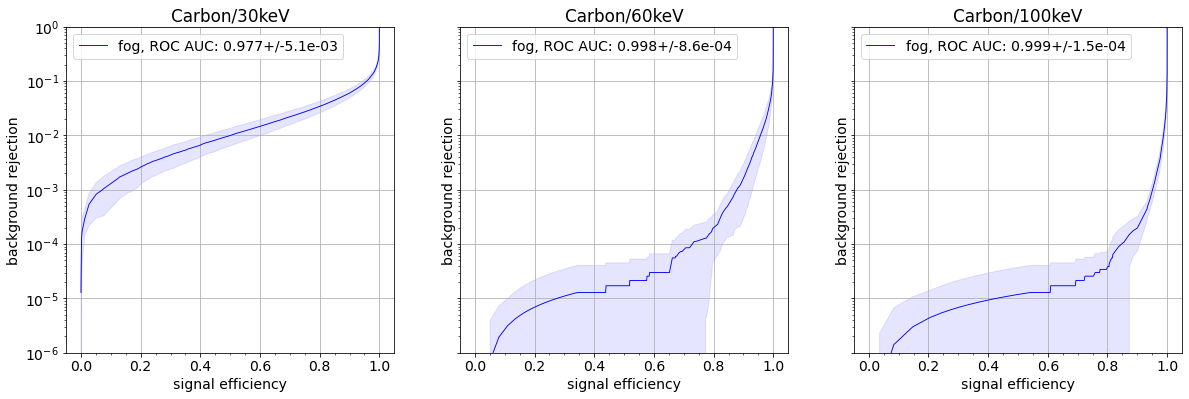

roc plots time: 0:00:03.756073


In [62]:
save_dir = '/home/scanner-ml/ML-drive/Artem/Colour_70nm/Oct2019_Feb2020_N123gf/plots/article/figures/'
sign = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV']

import scipy.interpolate
start = datetime.now()
preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
b = 'fog'
for s in sign:
    mask = np.bitwise_or(y_test_tot==categ_dict_test[b], y_test_tot==categ_dict_test[s])
    preds0 = (test_preds_tot.T)[mask]
    y_true_sb = y_test_tot[mask]<n_sig_cl
    #preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
    preds[s] = preds0.T
    aucs[s] = [roc_auc_score(y_true_sb, pr) for pr in preds0.T]

sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_test_tot==categ_dict_test[b], y_test_tot==categ_dict_test[s])
    y_true_sb = y_test_tot[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        #f_mask = fpr>0
        #fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value=(fpr[0], fpr[-1]) ))#'extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    #f_mask = fpr>0
    #fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))
    
    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    gc.collect()

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    #thresh_half = thr[i_half]
    
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.1e}'.format(mean_aucs[s], std_aucs[s]))
    
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    axes[j].fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=col[b],alpha=0.1 )
   
    axes[j].legend(loc=2)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('signal efficiency')
    #axes[j].set_xlim(0.05, 1.0)
    axes[j].set_ylim(1e-6, 1.0)
    axes[j].set_ylabel('background rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.savefig(save_dir+'ml_roc_col_test.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print('roc plots time:', datetime.now()-start)

In [41]:
np.unique(y_test_tot, return_counts=True)

(array([0., 1., 2., 3.]), array([28656, 45901, 27101, 23365]))

In [42]:
1/23365

4.2799058420714746e-05

## Performance on validation

In [15]:
best_kek = KerasClassifierNews(build_fn=net_create_2d, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=50, validation_split=3000, verbose=1, checkpoint_name=None, **dict_bay_param)
best_kek.load_model('model_150iter_4cl.h5', custom_objects={'swish': swish, 'bentropy':balanced_crossentropy(mu=dict_bay_param['loss_mu'], n_sig_cl=3)})
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/'


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 50, 'validation_split': 3000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 100.0, 'betaa2': 1500.0, 'decay': 0.015560370138015383, 'drop_end': 0.0, 'drop_middle': 0.6884329966834594, 'loss_mu': 0.01, 'lr': 0.00044557109681541026, 'n_conv2': 64, 'n_conv3': 39, 'n_resid': 2} 



In [16]:
# del X_tr, y_tr; gc.collect()

class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']

with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    X_fog, y_fog = data_sb['val/images'][...], data_sb['val/labels'][...]

fog_pred = best_kek.predict_proba(X_fog)
np.savetxt('predict_isol_vs_fog.txt', fog_pred)
y_true_sb = y_fog<categ_dict['fog']
preds_sb = np.sum(fog_pred[:,:categ_dict['fog']],axis=1)
print('Carbon vs fog ROC AUC:',roc_auc_score(y_true_sb, preds_sb))
    
mask = y_fog!=3
y_fog = y_fog[mask]
gc.collect();

30600/30600 [==============================] - 6s 197us/step
Carbon vs fog ROC AUC: 0.9970302431757017


## Performance on test

In [17]:
#with h5py.File('../data/data_ready_4.h5','r') as df:
#    X_test = df['val/images'][...]
#    y_test = df['val/labels'][...]
categ_dict = {'Carbon/30keV':0,'Carbon/60keV':1,'Carbon/100keV':2,'fog':3}
X_test = np.ones((0,40,40,4))
y_test = []
with h5py.File(dset+'data_scale_ims_col_40.h5','r') as df:
    for name in ['Carbon/100keV','Carbon/60keV','Carbon/30keV','fog']:
        X_test = np.vstack((X_test, df['test/'+name+'/images'][...]))
        y_test = np.append(y_test, np.ones(df['test/'+name+'/images'].shape[0])*categ_dict[name])
print(X_test.shape, y_test.shape)
print(best_kek.score(X_test, y_test))

(125023, 40, 40, 4) (125023,)
125023/125023 [==============================] - 21s 166us/step
0.9937668664330759


In [18]:
y_pred = best_kek.predict_proba(X_test)
y_pred.shape

125023/125023 [==============================] - 20s 164us/step


(125023, 4)

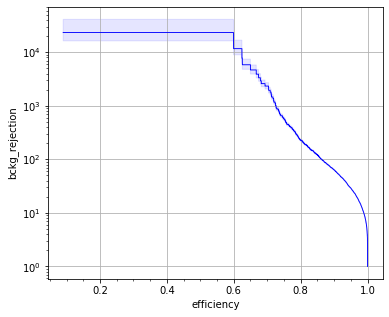

In [19]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
plt.figure(figsize=(6,5))
fpr, tpr, thr = roc_curve(y_test<3,np.sum(y_pred[:,:3], axis=1))
mask = tpr>0.1
i=0
while (not (fpr[mask])[i]): i+=1
#print(i,len(fpr),'\t',(fpr[mask])[i])
fpr = np.append([(fpr[mask])[i]], (fpr[mask])[i:])
tpr = np.append([0.09], (tpr[mask])[i:])
sigm = np.sqrt(fpr*(1-fpr)/y_pred.shape[0])
plt.plot(tpr,(fpr)**-1,linewidth=0.9,color='blue')
plt.fill( np.append(tpr,tpr[::-1]),np.append((fpr-sigm)**-1,((fpr+sigm)**-1)[::-1]),color='blue',alpha=0.1 )
plt.grid()
plt.minorticks_on()
plt.xlabel('efficiency')
plt.ylabel('bckg_rejection')
plt.yscale('log')

C30keV vs fog
thresh:	 0.9847875 
eff:	 0.6461125069793412 
rej:	 77.62458471760797
C60keV vs fog
thresh:	 0.9848098 
eff:	 0.9736389185420797 
rej:	 77.62458471760797
C100keV vs fog
thresh:	 0.9848503 
eff:	 0.9843179218479023 
rej:	 77.62458471760797


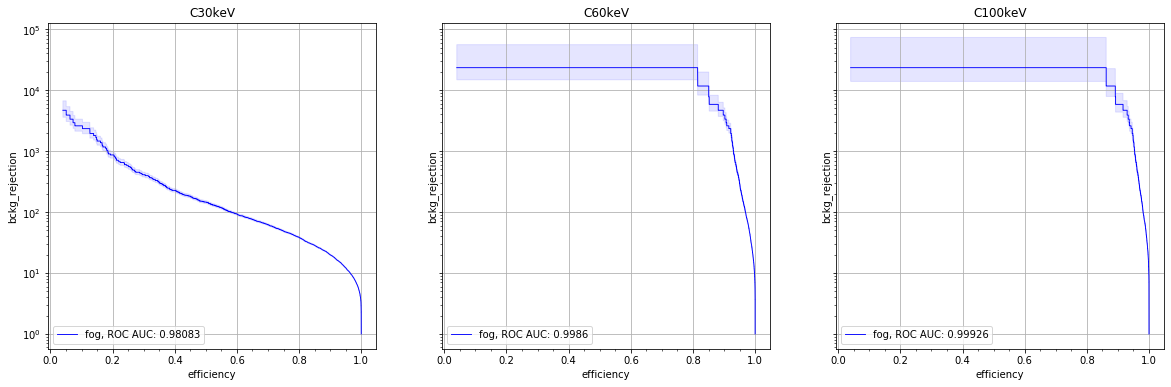

In [20]:
# TEST DATA
n_sig_cl=3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']
#thresh_half = {}
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
    #for b in bckg:
    b = 'fog'
    #mask = np.zeros(len(y_val), dtype=bool)
    mask = np.bitwise_or(y_test==categ_dict[b], y_test==categ_dict[s])
    preds0 = y_pred[mask]
    y_true_sb = y_test[mask]<n_sig_cl
    preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
    auc = roc_auc_score(y_true_sb, preds0_sb)
    #preds0_sb[:,1], preds90_sb[:,1] = np.sum(preds0[:,n_sig_cl:],axis=1), np.sum(preds90[:,n_sig_cl:],axis=1)

    #plt.figure(figsize=(7,7))
    fpr, tpr, thr = roc_curve(y_true_sb,preds0_sb)

    i_half = np.argmin(thr>0.985)#0.99763) 
    #i_half = np.argmax(tpr>0.35)
    #if s+' '+b in ['C30keV fog','C60keV gamma','C100keV gamma_no']:
    print(s,'vs',b);
    print('thresh:\t',thr[i_half],'\neff:\t',tpr[i_half],'\nrej:\t',(fpr[i_half])**-1)
    thresh_half = thr[i_half]

    mask = tpr>0.05
    i=0
    while (not (fpr[mask])[i]): i+=1
    #print(i,len(fpr),'\t',(fpr[mask])[i])
    fpr = np.append([(fpr[mask])[i]], (fpr[mask])[i:])
    tpr = np.append([0.04], (tpr[mask])[i:])
    sigm = np.sqrt(fpr*(1-fpr)/y_true_sb.shape[0])
    axes[j].plot(tpr,(fpr)**-1,linewidth=0.9,color='blue',label=b+', ROC AUC: '+str(np.round(auc, 5)))
    axes[j].fill( np.append(tpr,tpr[::-1]),np.append((fpr-sigm)**-1,((fpr+sigm)**-1)[::-1]),color='blue',alpha=0.1 )
    axes[j].legend(loc=3)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('efficiency')
    axes[j].set_ylabel('bckg_rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.show()

## NO MATCH WITH POL

## using the best result of Bayes Opt

In [7]:
from collections import OrderedDict
#bay_param = pd.read_csv('bayes_params_sorted.csv', index_col=0)
bay_res = pd.read_csv('bayes_checkpoint_results.csv', index_col=0).sort_values(by='mean_test_score', ascending=False, axis=0)
bay_param = pd.DataFrame([eval(i) for i in bay_res['params']], index=bay_res['params'].index)
dict_bay_param = dict(bay_param.iloc[0])
for k, val in dict_bay_param.items():
    if k.startswith('n_'): dict_bay_param[k] = int(val)
dict_bay_param

{'betaa1': 100.0,
 'betaa2': 1500.0,
 'decay': 0.015560370138015383,
 'drop_end': 0.0,
 'drop_middle': 0.6884329966834594,
 'loss_mu': 0.01,
 'lr': 0.00044557109681541026,
 'n_conv2': 64,
 'n_conv3': 39,
 'n_resid': 2}

In [7]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/70nm_nomatch/'
with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create_2d, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=50, validation_split=3000, verbose=1, checkpoint_name=None, **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 50, 'validation_split': 3000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 100.0, 'betaa2': 1500.0, 'decay': 0.015560370138015383, 'drop_end': 0.0, 'drop_middle': 0.6884329966834594, 'loss_mu': 0.01, 'lr': 0.00044557109681541026, 'n_conv2': 64, 'n_conv3': 39, 'n_resid': 2} 

Epoch 1/50
691/691 [==============================] - 268s 388ms/step - loss: 0.2637 - val_loss: 0.4038
Epoch 2/50
691/691 [==============================] - 238s 344ms/step - loss: 0.1485 - val_loss: 2.9662
Epoch 3/50
691/691 [==============================] - 242s 351ms/step - loss: 0.1264 - val_loss: 0.6262
Epoch 4/50
691/691 [==============================] - 237s 343ms/step - loss: 0.1127 - val_loss: 0.1184
Epoch 5/50
691/691 [==============================] - 242s 350ms/step - loss: 0.1042 - val_loss: 0.5732
Epoch 6/50
691/691 [==============================] - 240s 348ms/step - loss: 0.0976 - val_loss: 1.5490
Epoch 7/50
691/691 [======

Process ForkPoolWorker-252:
Process ForkPoolWorker-250:
Process ForkPoolWorker-249:
Process ForkPoolWorker-251:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/scanner-ml/anaconda3/envs/ML_bckp/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/scanner-ml/anaconda3/envs/ML_bckp/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/scanner-ml/anaconda3/envs/ML_bckp/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/scanner-ml/anaconda3/envs/ML_bckp/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/scanner-ml/anaconda3/envs/ML_bckp/lib/python3.7/site-packages/keras/utils/data_utils.py", line 406, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/mnt/ML-drive/Artem/Python/NEWS/colour/CNN/cnn_ut

KeyboardInterrupt: 

In [8]:
best_kek.save_model('model_150iter_4cl_nomatch.h5')
del X_tr, y_tr; gc.collect();

## Performance on validation

In [6]:
from collections import OrderedDict
#bay_param = pd.read_csv('bayes_params_sorted.csv', index_col=0)
bay_res = pd.read_csv('bayes_checkpoint_results.csv', index_col=0).sort_values(by='mean_test_score', ascending=False, axis=0)
bay_param = pd.DataFrame([eval(i) for i in bay_res['params']], index=bay_res['params'].index)
dict_bay_param = dict(bay_param.iloc[0])
for k, val in dict_bay_param.items():
    if k.startswith('n_'): dict_bay_param[k] = int(val)
dict_bay_param

{'betaa1': 100.0,
 'betaa2': 1500.0,
 'decay': 0.015560370138015383,
 'drop_end': 0.0,
 'drop_middle': 0.6884329966834594,
 'loss_mu': 0.01,
 'lr': 0.00044557109681541026,
 'n_conv2': 64,
 'n_conv3': 39,
 'n_resid': 2}

In [7]:
best_kek = KerasClassifierNews(build_fn=net_create_2d, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=50, validation_split=3000, verbose=1, checkpoint_name=None, **dict_bay_param)
best_kek.load_model('model_150iter_4cl_nomatch.h5', custom_objects={'swish': swish, 'bentropy':balanced_crossentropy(mu=dict_bay_param['loss_mu'], n_sig_cl=3)})
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/70nm_nomatch/'


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 50, 'validation_split': 3000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 100.0, 'betaa2': 1500.0, 'decay': 0.015560370138015383, 'drop_end': 0.0, 'drop_middle': 0.6884329966834594, 'loss_mu': 0.01, 'lr': 0.00044557109681541026, 'n_conv2': 64, 'n_conv3': 39, 'n_resid': 2} 



In [8]:
# del X_tr, y_tr; gc.collect()

class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']

with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    X_fog, y_fog = data_sb['val/images'][...], data_sb['val/labels'][...]

fog_pred = best_kek.predict_proba(X_fog)
np.savetxt('predict_isol_vs_fog.txt', fog_pred)
y_true_sb = y_fog<categ_dict['fog']
preds_sb = np.sum(fog_pred[:,:categ_dict['fog']],axis=1)
print('Carbon vs fog ROC AUC:',roc_auc_score(y_true_sb, preds_sb))
    
mask = y_fog!=3
y_fog = y_fog[mask]
gc.collect();

30600/30600 [==============================] - 12s 404us/step
Carbon vs fog ROC AUC: 0.996288516435986


## Performance on test

In [9]:
#with h5py.File('../data/data_ready_4.h5','r') as df:
#    X_test = df['val/images'][...]
#    y_test = df['val/labels'][...]
categ_dict = {'Carbon/30keV':0,'Carbon/60keV':1,'Carbon/100keV':2,'fog':3}
X_test = np.ones((0,40,40,4))
y_test = []
y_pred = np.zeros((0,4))
with h5py.File(dset+'data_scale_ims_col_40.h5','r') as df:
    for name in ['Carbon/100keV','Carbon/60keV','Carbon/30keV','fog']:
        X_test = df['test/'+name+'/images'][...]
        y_test = np.append(y_test, np.ones(df['test/'+name+'/images'].shape[0])*categ_dict[name])
        y_pred = np.vstack((y_pred, best_kek.predict_proba(X_test)))
print(y_pred.shape, y_test.shape)

y_true_sb = y_test<3
preds_sb = np.sum(y_pred[:,:3],axis=1)
print('test score: {:.4f}'.format(roc_auc_score(y_true_sb, preds_sb)))

172270/172270 [==============================] - 28s 161us/step
(352554, 4) (352554,)
test score: 0.9828


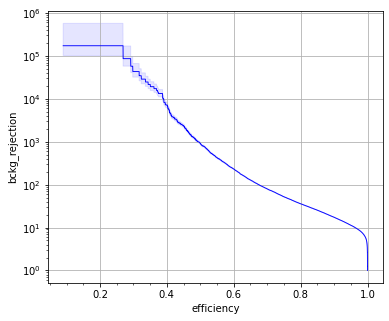

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
plt.figure(figsize=(6,5))
fpr, tpr, thr = roc_curve(y_test<3,np.sum(y_pred[:,:3], axis=1))
mask = tpr>0.1
i=0
while (not (fpr[mask])[i]): i+=1
#print(i,len(fpr),'\t',(fpr[mask])[i])
fpr = np.append([(fpr[mask])[i]], (fpr[mask])[i:])
tpr = np.append([0.09], (tpr[mask])[i:])
sigm = np.sqrt(fpr*(1-fpr)/y_pred.shape[0])
plt.plot(tpr,(fpr)**-1,linewidth=0.9,color='blue')
plt.fill( np.append(tpr,tpr[::-1]),np.append((fpr-sigm)**-1,((fpr+sigm)**-1)[::-1]),color='blue',alpha=0.1 )
plt.grid()
plt.minorticks_on()
plt.xlabel('efficiency')
plt.ylabel('bckg_rejection')
plt.yscale('log')

C30keV vs fog
thresh:	 0.9849996591219679 
eff:	 0.3873187007114101 
rej:	 63.993313521545325
C60keV vs fog
thresh:	 0.9849976748228073 
eff:	 0.9374117135716614 
rej:	 63.94580549368969
C100keV vs fog
thresh:	 0.9849911972414702 
eff:	 0.9672319678636798 
rej:	 63.874675565443084


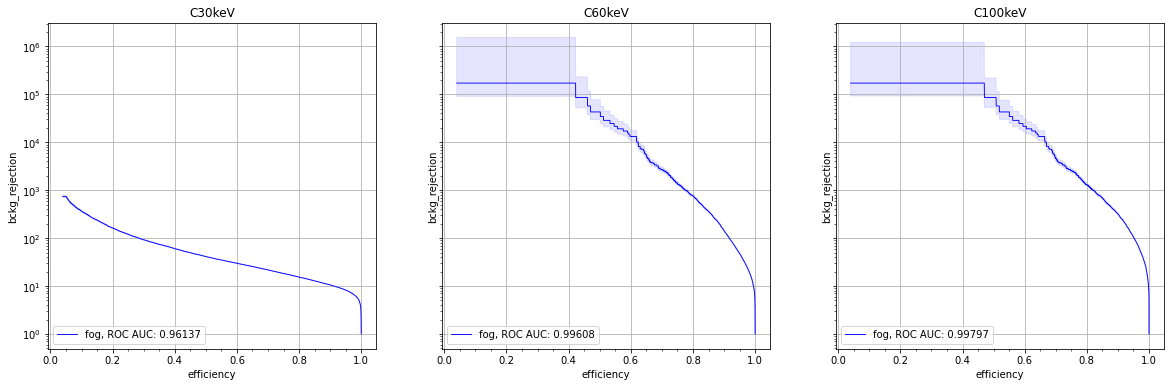

In [11]:
# TEST DATA
n_sig_cl=3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']
#thresh_half = {}
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
    #for b in bckg:
    b = 'fog'
    #mask = np.zeros(len(y_val), dtype=bool)
    mask = np.bitwise_or(y_test==categ_dict[b], y_test==categ_dict[s])
    preds0 = y_pred[mask]
    y_true_sb = y_test[mask]<n_sig_cl
    preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
    auc = roc_auc_score(y_true_sb, preds0_sb)
    #preds0_sb[:,1], preds90_sb[:,1] = np.sum(preds0[:,n_sig_cl:],axis=1), np.sum(preds90[:,n_sig_cl:],axis=1)

    #plt.figure(figsize=(7,7))
    fpr, tpr, thr = roc_curve(y_true_sb,preds0_sb)

    i_half = np.argmin(thr>0.985)#0.99763) 
    #i_half = np.argmax(tpr>0.35)
    #if s+' '+b in ['C30keV fog','C60keV gamma','C100keV gamma_no']:
    print(s,'vs',b);
    print('thresh:\t',thr[i_half],'\neff:\t',tpr[i_half],'\nrej:\t',(fpr[i_half])**-1)
    thresh_half = thr[i_half]

    mask = tpr>0.05
    i=0
    while (not (fpr[mask])[i]): i+=1
    #print(i,len(fpr),'\t',(fpr[mask])[i])
    fpr = np.append([(fpr[mask])[i]], (fpr[mask])[i:])
    tpr = np.append([0.04], (tpr[mask])[i:])
    sigm = np.sqrt(fpr*(1-fpr)/y_true_sb.shape[0])
    axes[j].plot(tpr,(fpr)**-1,linewidth=0.9,color='blue',label=b+', ROC AUC: '+str(np.round(auc, 5)))
    axes[j].fill( np.append(tpr,tpr[::-1]),np.append((fpr-sigm)**-1,((fpr+sigm)**-1)[::-1]),color='blue',alpha=0.1 )
    axes[j].legend(loc=3)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('efficiency')
    axes[j].set_ylabel('bckg_rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.show()

## Old pre-trained network

In [6]:
from collections import OrderedDict
#bay_param = pd.read_csv('bayes_params_sorted.csv', index_col=0)
bay_res = pd.read_csv('bayes_checkpoint_results.csv', index_col=0).sort_values(by='mean_test_score', ascending=False, axis=0)
bay_param = pd.DataFrame([eval(i) for i in bay_res['params']], index=bay_res['params'].index)
dict_bay_param = dict(bay_param.iloc[0])
for k, val in dict_bay_param.items():
    if k.startswith('n_'): dict_bay_param[k] = int(val)
dict_bay_param

{'betaa1': 100.0,
 'betaa2': 1500.0,
 'decay': 0.015560370138015383,
 'drop_end': 0.0,
 'drop_middle': 0.6884329966834594,
 'loss_mu': 0.01,
 'lr': 0.00044557109681541026,
 'n_conv2': 64,
 'n_conv3': 39,
 'n_resid': 2}

In [7]:
best_kek = KerasClassifierNews(build_fn=net_create_2d, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=50, validation_split=3000, verbose=1, checkpoint_name=None, **dict_bay_param)
best_kek.load_model('model_150iter_4cl.h5', custom_objects={'swish': swish, 'bentropy':balanced_crossentropy(mu=dict_bay_param['loss_mu'], n_sig_cl=3)})
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/70nm_nomatch/'


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 50, 'validation_split': 3000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 100.0, 'betaa2': 1500.0, 'decay': 0.015560370138015383, 'drop_end': 0.0, 'drop_middle': 0.6884329966834594, 'loss_mu': 0.01, 'lr': 0.00044557109681541026, 'n_conv2': 64, 'n_conv3': 39, 'n_resid': 2} 



In [9]:
# del X_tr, y_tr; gc.collect()

class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']

with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    X_fog, y_fog = data_sb['val/images'][...], data_sb['val/labels'][...]

fog_pred = best_kek.predict_proba(X_fog)
np.savetxt('predict_isol_vs_fog.txt', fog_pred)
y_true_sb = y_fog<categ_dict['fog']
preds_sb = np.sum(fog_pred[:,:categ_dict['fog']],axis=1)
print('Carbon vs fog ROC AUC:',roc_auc_score(y_true_sb, preds_sb))
    
mask = y_fog!=3
y_fog = y_fog[mask]
gc.collect();

30600/30600 [==============================] - 16s 528us/step
Carbon vs fog ROC AUC: 0.997036065455594


## Performance on test

In [8]:
#with h5py.File('../data/data_ready_4.h5','r') as df:
#    X_test = df['val/images'][...]
#    y_test = df['val/labels'][...]
categ_dict = {'Carbon/30keV':0,'Carbon/60keV':1,'Carbon/100keV':2,'fog':3}
X_test = np.ones((0,40,40,4))
y_test = []
y_pred = np.zeros((0,4))
with h5py.File(dset+'data_scale_ims_col_40.h5','r') as df:
    for name in ['Carbon/100keV','Carbon/60keV','Carbon/30keV','fog']:
        X_test = df['test/'+name+'/images'][...]
        y_test = np.append(y_test, np.ones(df['test/'+name+'/images'].shape[0])*categ_dict[name])
        y_pred = np.vstack((y_pred, best_kek.predict_proba(X_test)))
print(y_pred.shape, y_test.shape)

y_true_sb = y_test<3
preds_sb = np.sum(y_pred[:,:3],axis=1)
print('test score: {:.4f}'.format(roc_auc_score(y_true_sb, preds_sb)))

172270/172270 [==============================] - 28s 162us/step
(416063, 4) (416063,)
test score: 0.9895


In [11]:
y_true_sb = y_test<3
preds_sb = np.sum(y_pred[:,:3],axis=1)
print('test score: {:.4f}'.format(roc_auc_score(y_true_sb, preds_sb)))

test score: 0.9869


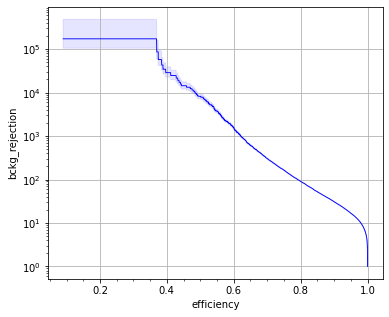

In [9]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
plt.figure(figsize=(6,5))
fpr, tpr, thr = roc_curve(y_test<3,np.sum(y_pred[:,:3], axis=1))
mask = tpr>0.1
i=0
while (not (fpr[mask])[i]): i+=1
#print(i,len(fpr),'\t',(fpr[mask])[i])
fpr = np.append([(fpr[mask])[i]], (fpr[mask])[i:])
tpr = np.append([0.09], (tpr[mask])[i:])
sigm = np.sqrt(fpr*(1-fpr)/y_pred.shape[0])
plt.plot(tpr,(fpr)**-1,linewidth=0.9,color='blue')
plt.fill( np.append(tpr,tpr[::-1]),np.append((fpr-sigm)**-1,((fpr+sigm)**-1)[::-1]),color='blue',alpha=0.1 )
plt.grid()
plt.minorticks_on()
plt.xlabel('efficiency')
plt.ylabel('bckg_rejection')
plt.yscale('log')

C30keV vs fog
thresh:	 0.9849995731055969 
eff:	 0.6313206302070444 
rej:	 43.15380761523046
C60keV vs fog
thresh:	 0.9849994839169085 
eff:	 0.9608115772333925 
rej:	 43.14300025043827
C100keV vs fog
thresh:	 0.984959632740356 
eff:	 0.9825712295705978 
rej:	 43.09982486865149


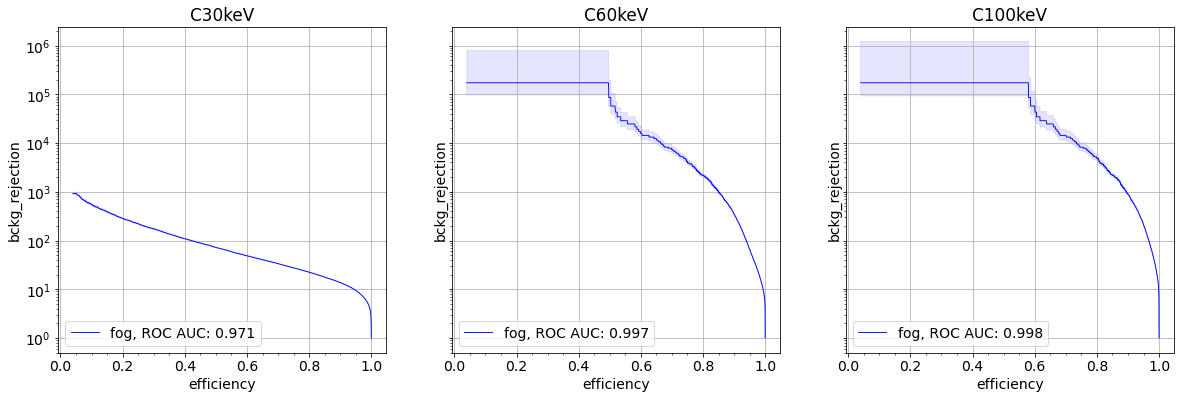

In [13]:
# TEST DATA
n_sig_cl=3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']
#thresh_half = {}
plt.rc('font',size=14)
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
    #for b in bckg:
    b = 'fog'
    #mask = np.zeros(len(y_val), dtype=bool)
    mask = np.bitwise_or(y_test==categ_dict[b], y_test==categ_dict[s])
    preds0 = y_pred[mask]
    y_true_sb = y_test[mask]<n_sig_cl
    preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
    auc = roc_auc_score(y_true_sb, preds0_sb)
    #preds0_sb[:,1], preds90_sb[:,1] = np.sum(preds0[:,n_sig_cl:],axis=1), np.sum(preds90[:,n_sig_cl:],axis=1)

    #plt.figure(figsize=(7,7))
    fpr, tpr, thr = roc_curve(y_true_sb,preds0_sb)

    i_half = np.argmin(thr>0.985)#0.99763) 
    #i_half = np.argmax(tpr>0.35)
    #if s+' '+b in ['C30keV fog','C60keV gamma','C100keV gamma_no']:
    print(s,'vs',b);
    print('thresh:\t',thr[i_half],'\neff:\t',tpr[i_half],'\nrej:\t',(fpr[i_half])**-1)
    thresh_half = thr[i_half]

    mask = tpr>0.05
    i=0
    while (not (fpr[mask])[i]): i+=1
    #print(i,len(fpr),'\t',(fpr[mask])[i])
    fpr = np.append([(fpr[mask])[i]], (fpr[mask])[i:])
    tpr = np.append([0.04], (tpr[mask])[i:])
    sigm = np.sqrt(fpr*(1-fpr)/y_true_sb.shape[0])
    axes[j].plot(tpr,(fpr)**-1,linewidth=0.9,color='blue',label=b+', ROC AUC: '+str(np.round(auc, 3)))
    axes[j].fill( np.append(tpr,tpr[::-1]),np.append((fpr-sigm)**-1,((fpr+sigm)**-1)[::-1]),color='blue',alpha=0.1 )
    axes[j].legend(loc=3)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('efficiency')
    axes[j].set_ylabel('bckg_rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.show()